# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [59]:
# Import your libraries:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import mysql.connector
import seaborn as sns

In [2]:
import sqlalchemy
>>> sqlalchemy.__version__ 

'1.4.22'

In [3]:
#Create a connection with create_engine to MySQL Workbench:
import getpass
password = getpass.getpass()

········


In [5]:
pip install PyMySQL

Note: you may need to restart the kernel to use updated packages.


In [6]:
engine = create_engine("mysql+pymysql://{user}:{password}@{host}/{db}"
                       .format(user='root', password=password, host='localhost', db='lab_unsupervised_learning'))

In [7]:
connect_db = engine.connect()

In [12]:
df_wholesale = pd.read_sql('SELECT * FROM wholesale_customers_data', engine) 
df_wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [19]:
# Your code here:
display(df_wholesale.describe())
print(df_wholesale.shape)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


(440, 8)


In [16]:
df_wholesale.info()

#no need to convert any columns as they are all numericals

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [20]:
# Your observations here
df_wholesale.isna().sum()
#no need to re

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

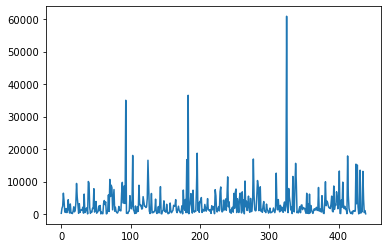

In [22]:
plt.plot(df_wholesale['Frozen'])
plt.show()

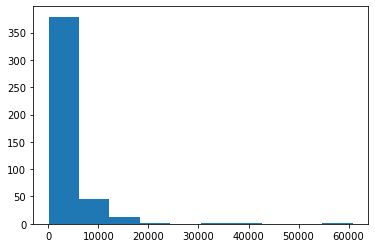

In [31]:
plt.hist(df_wholesale['Frozen'])
plt.show()

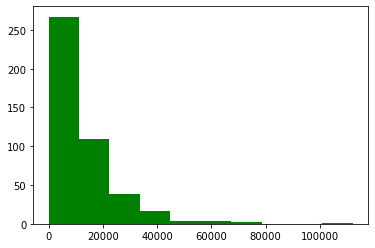

In [32]:
plt.hist(df_wholesale['Fresh'],color='green')
plt.show()

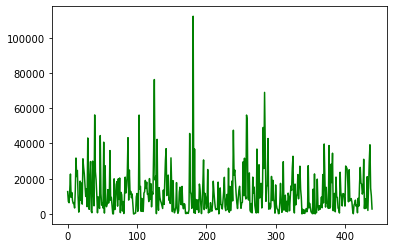

In [34]:
plt.plot(df_wholesale['Fresh'],color='green')
plt.show()

<AxesSubplot:ylabel='Frequency'>

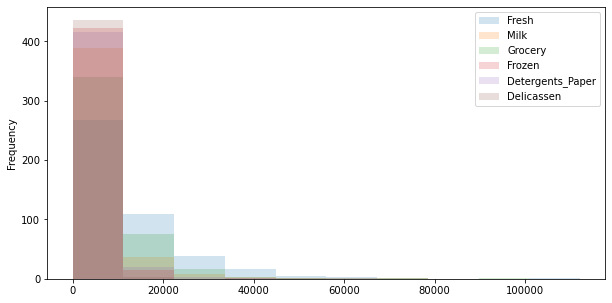

In [58]:
columns = df_wholesale[['Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']]

columns.plot.hist(alpha=0.2, figsize=(10, 5))

<AxesSubplot:>

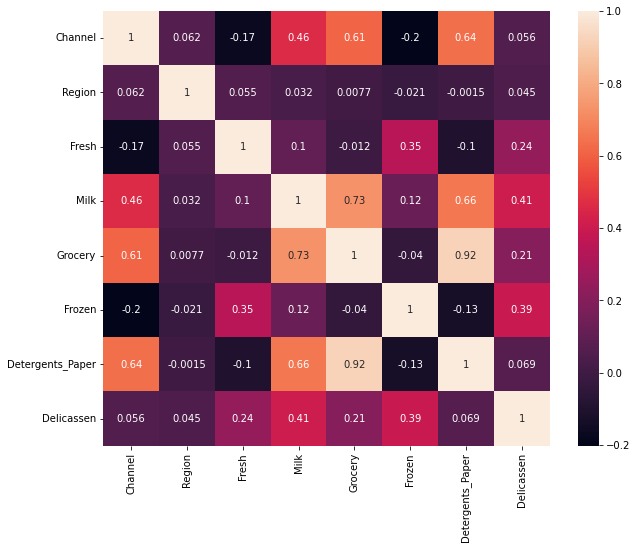

In [50]:
plt.figure(figsize=(10,8))
sns.heatmap(df_wholesale.corr(),annot=True,cbar=True)

<AxesSubplot:>

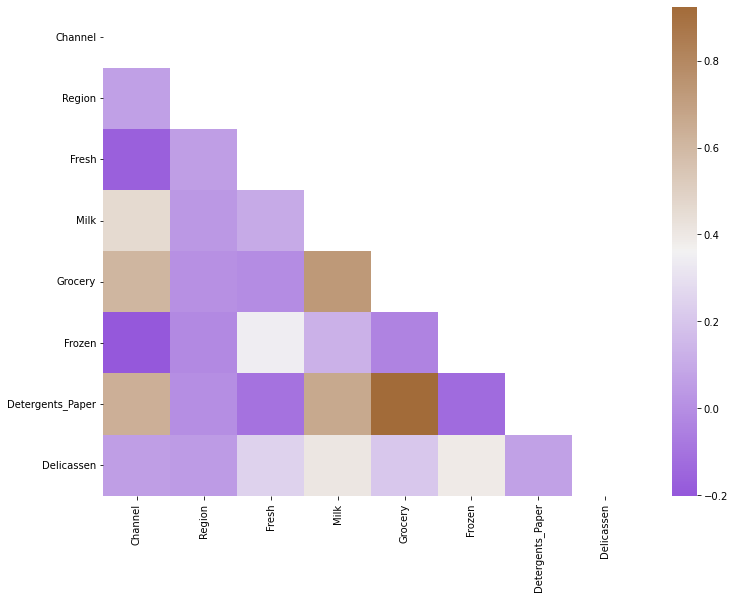

In [49]:
figsales = plt.figure(figsize=(12,9))
corr_mat = df_wholesale.corr()

cmap = sns.diverging_palette(280, 40, as_cmap=True)
sns.heatmap(corr_mat, cmap=cmap, mask=mask)

#we detect high correlation between grocery and detertengs paper and grocery and milk


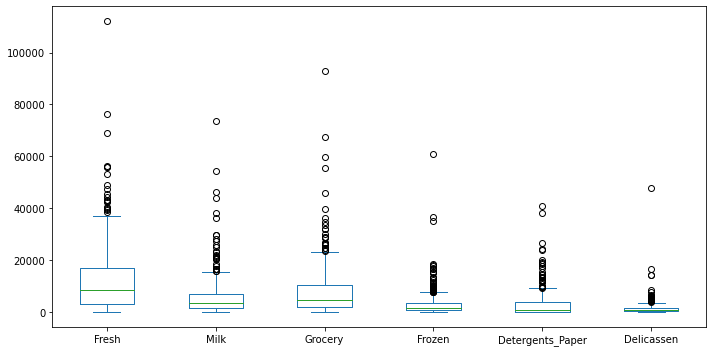

In [63]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
plotsale = df_wholesale[['Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']].plot(kind='box')

plt.show()

#we can see that we have lot of outliers


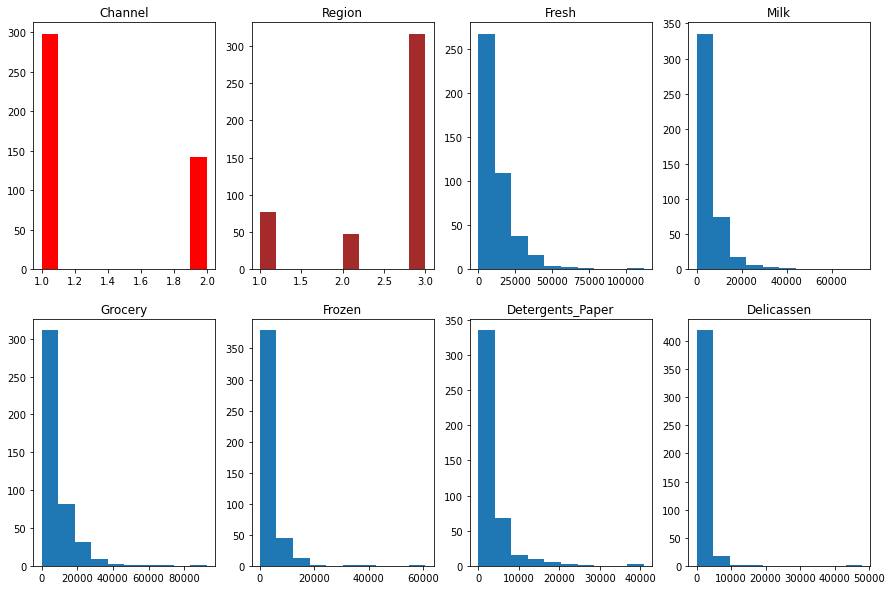

In [54]:
figure, axis = plt.subplots(2, 4, figsize=[15,10])

axis[0, 0].hist(df_wholesale['Channel'],color='red')
axis[0, 0].set_title("Channel")

axis[0, 1].hist(df_wholesale['Region'], color='brown')
axis[0, 1].set_title("Region")

axis[0, 2].hist(df_wholesale['Fresh'])
axis[0, 2].set_title("Fresh")

axis[0, 3].hist(df_wholesale['Milk'])
axis[0, 3].set_title("Milk")

axis[1, 0].hist(df_wholesale['Grocery'])
axis[1, 0].set_title("Grocery")

axis[1, 1].hist(df_wholesale['Frozen'])
axis[1, 1].set_title("Frozen")

axis[1, 2].hist(df_wholesale['Detergents_Paper'])
axis[1, 2].set_title("Detergents_Paper")

axis[1, 3].hist(df_wholesale['Delicassen'])
axis[1, 3].set_title("Delicassen")

plt.show()

#Channel and region are more contextual data, where they are coming from 
#while the rest of the data are left screwed

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [67]:
# let´s remove the outliers to have a clean dataset. https://www.codegrepper.com/code-examples/python/how+to+calculate+iqr+in+pandas

q1=df_wholesale["Fresh"].quantile(0.25)
q3=df_wholesale["Fresh"].quantile(0.75)

IQR=q3-q1

out = df_wholesale[~((df_wholesale < (q1 - 1.9 * IQR)) |(df_wholesale > (q3 + 1.9 * IQR))).any(axis=1)]
out

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [68]:
# Your comment here
out.drop(['Grocery'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [69]:
df_wholesale

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [77]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()

In [100]:
customers_scale = pd.DataFrame(df_wholesale[['Channel', 'Region']])
customers_scale[['Fresh', 'Milk','Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]= scaler.fit_transform(df_wholesale[[
    'Fresh', 'Milk','Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']])

In [101]:
customers_scale

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,2,3,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,2,3,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,1,3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,2,3,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347
...,...,...,...,...,...,...,...,...
435,1,3,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091
436,1,3,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501
437,2,3,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,1,3,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [102]:
# Your code here:
from sklearn.cluster import KMeans

kmeans = KMeans()
kmeans.fit(customers_scale)
pred = kmeans.predict(customers_scale)
customers_scale["labels"] = kmeans.labels_

Count the values in `labels`.

In [103]:
# Your code here:
customers_scale["labels"].value_counts()

7    163
3     87
0     84
6     50
2     42
1     11
4      2
5      1
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [91]:
# Your code here
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=0.5).fit(customers_scale)
# get cluster labels
clusters.labels_

array([ 0,  0, -1,  3, -1,  0, -1,  0,  1,  0, -1, -1, -1, -1, -1,  1,  0,
       -1, -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  2, -1,  1,  1, -1,
        1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,  0, -1, -1, -1,  1,
        1, -1,  0,  1,  1, -1,  0,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1,  1,  3, -1, -1, -1,  0,  1, -1, -1,  1,  1,  1,  0,  0,  1, -1,
       -1, -1, -1,  3, -1,  1,  3, -1, -1,  0,  1,  4,  1,  1,  1, -1,  0,
        0, -1,  1,  1,  0, -1,  0, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1, -1, -1, -1,  3, -1, -1,  2,  1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1, -1, -1, -1,  3,  1, -1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1, -1, -1,  1,  0,  0,  0,  1,  1, -1, -1, -1, -1,  1,  1,  1,
        0, -1,  1,  0,  1,  0, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1,  1,
       -1, -1,  0, -1,  1,  1,  4,  1, -1, -1, -1,  5,  5, -1, -1, -1,  5,
        5, -1,  5, -1, -1, -1,  5, -1,  5, -1, -1, -1, -1,  5, -1,  5,  5,
       -1,  6, -1,  5,  5

Count the values in `labels_DBSCAN`.

In [104]:
# Your code here
customers_scale['labels_DBSCAN'] = clusters.labels_
customers_scale['labels_DBSCAN'].value_counts()

-1    213
 1    132
 0     35
 5     23
 7     14
 3      9
 6      6
 2      5
 4      3
Name: labels_DBSCAN, dtype: int64

In [105]:
customers_scale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,0,0
1,2,3,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,0,0
2,2,3,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,0,-1
3,1,3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,7,3
4,2,3,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,0,-1


# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

<function matplotlib.pyplot.show(close=None, block=None)>

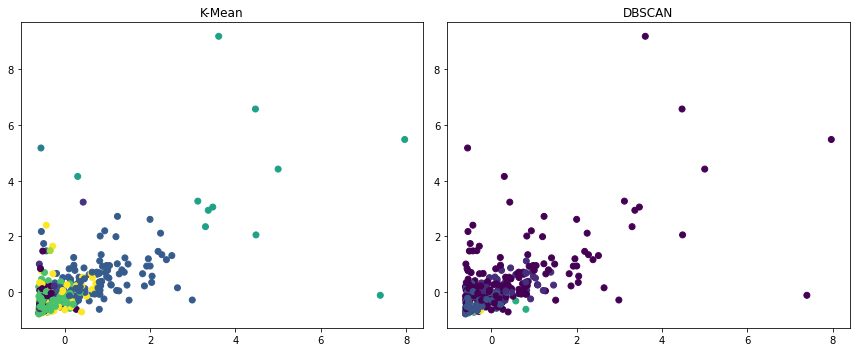

In [98]:
# Your code here:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))

# For Sine Function
axis[ 0].scatter(customers_scale['Detergents_Paper'], customers_scale['Milk'], c=customers_scale['labels'])
axis[ 0].set_title("K-Mean")
  
# For Cosine Function
axis[1].scatter(customers_scale['Detergents_Paper'], customers_scale['Milk'],c=customers_scale['labels_DBSCAN'])
axis[1].set_title("DBSCAN")
plt.show

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

<function matplotlib.pyplot.show(close=None, block=None)>

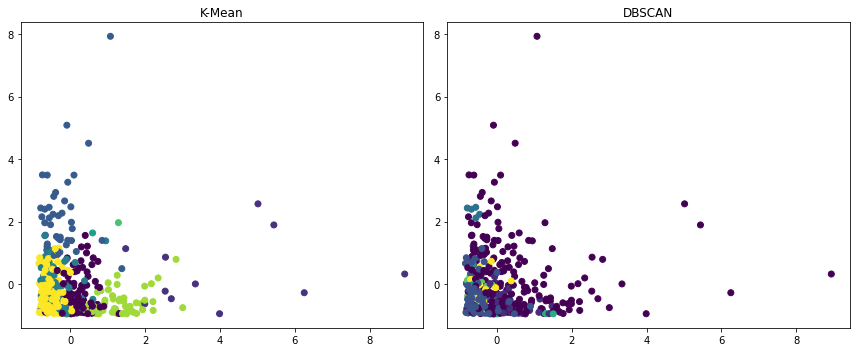

In [108]:
# Your code here:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))

# For Sine Function
axis[ 0].scatter(customers_scale['Grocery'], customers_scale['Fresh'], c=customers_scale['labels'])
axis[ 0].set_title("K-Mean")
  
# For Cosine Function
axis[1].scatter(customers_scale['Grocery'], customers_scale['Fresh'],c=customers_scale['labels_DBSCAN'])
axis[1].set_title("DBSCAN")
plt.show

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

<function matplotlib.pyplot.show(close=None, block=None)>

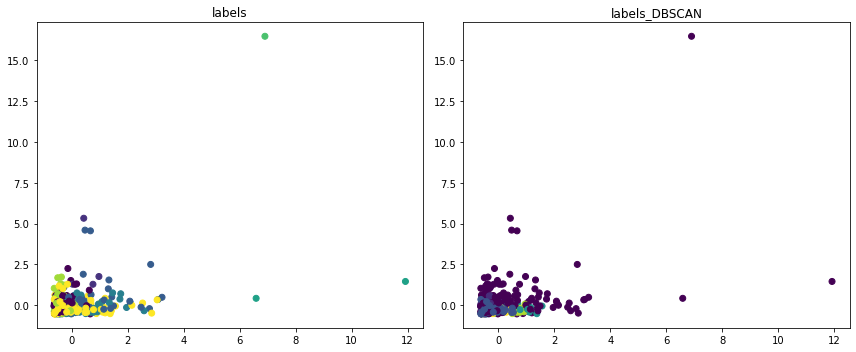

In [109]:
# Your code here:

# Your code here:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))

# For Sine Function
axis[ 0].scatter(customers_scale['Frozen'], customers_scale['Delicassen'], c=customers_scale['labels'])
axis[ 0].set_title("labels")
  
# For Cosine Function
axis[1].scatter(customers_scale['Frozen'], customers_scale['Delicassen'],c=customers_scale['labels_DBSCAN'])
axis[1].set_title("labels_DBSCAN")
plt.show

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [110]:
# Your code here:
customers_scale.groupby(['labels','labels_DBSCAN'])[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].mean()


Fresh      Milk   Grocery    Frozen  \
labels labels_DBSCAN                                           
0      -1             0.016063  0.188521  0.229753 -0.233251   
        0            -0.555987  0.262241  0.198373 -0.456338   
        1            -0.717972 -0.122880  0.298021 -0.571013   
        4            -0.941886 -0.372459  0.658817 -0.519664   
1      -1             0.388729  3.943049  4.021646  0.035784   
2      -1             2.157894 -0.031125 -0.171351  0.859807   
        2             2.330913 -0.593472 -0.609298 -0.370277   
3      -1            -0.145376 -0.192075 -0.306659  0.135441   
        5            -0.164813 -0.546246 -0.588567 -0.303392   
        6            -0.409825 -0.522690 -0.587695  0.764752   
        7            -0.046365 -0.565798 -0.378138 -0.151485   
4      -1             0.792784  0.561685 -0.011301  9.252557   
5      -1             1.966817  5.175503  1.287217  6.900600   
6      -1            -0.515374  0.991108  1.392383 -0.345794   
        0            -0.835370  0.521186  1.150101 -0.468842   
        4            -0.946992 -0.613304  1.508658 -0.605246   
7      -1            -0.060201 -0.097995 -0.413590  0.517531   
        1            -0.297118 -0.509245 -0.560750 -0.273483   
        3             0.168900 -0.550709 -0.569083  1.095623   

                      Detergents_Paper  Delicassen  
labels labels_DBSCAN                                
0      -1                     0.242366    0.059073  
        0                     0.303692    0.023667  
        1                    -0.001363   -0.105673  
        4                     0.391503   -0.384597  
1      -1                     4.226116    0.941636  
2      -1                    -0.405540    0.507975  
        2                    -0.517654   -0.262725  
3      -1                    -0.301239   -0.078385  
        5                    -0.532568   -0.303387  
        6                    -0.523890   -0.323478  
        7                    -0.498978   -0.235700  
4      -1                    -0.464047    0.933164  
5      -1                    -0.554862   16.478447  
6      -1                     1.385842    0.093402  
        0                     1.066951   -0.205184  
        4                     0.811666   -0.502279  
7      -1                    -0.445557    0.154037  
        1                    -0.487266   -0.285408  
        3                    -0.527378   -0.238514

Which algorithm appears to perform better?

In [ ]:
# Your observations here

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here